In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
# Function to preprocess data
def preprocess_data(df, scaler=None, label_encoders=None):
    # Identify numeric and non-numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
    
    # Fill missing values
    if not numeric_cols.empty:
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    if not non_numeric_cols.empty:
        df[non_numeric_cols] = df[non_numeric_cols].fillna(df[non_numeric_cols].mode().iloc[0])
    
    # Encode non-numeric columns
    if label_encoders is None:
        label_encoders = {}
        for col in non_numeric_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    else:
        for col in non_numeric_cols:
            le = label_encoders[col]
            df[col] = le.transform(df[col])
    
    # Standardize numeric columns
    if scaler is None:
        scaler = StandardScaler()
        if not numeric_cols.empty:
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        if not numeric_cols.empty:
            df[numeric_cols] = scaler.transform(df[numeric_cols])
    
    return df, scaler, label_encoders


In [7]:
# Load the train and test datasets
train_df = pd.read_excel(r"C:\Users\JOSMON\Downloads\AI_Enginner_Tasks\train.xlsx")
test_df = pd.read_excel(r"C:\Users\JOSMON\Downloads\AI_Enginner_Tasks\test.xlsx")

In [8]:
# Preprocess the training data
train_df, scaler, label_encoders = preprocess_data(train_df)

In [18]:
# Remove the 'target' column from the training data before fitting the KMeans model
train_df_no_target = train_df.drop(columns=['target'])


In [34]:
# Remove the 'Cluster' column from the training data before fitting the KMeans model
train_df_no_cluster = train_df_no_target.drop(columns=['Cluster'])

In [45]:
# Print the shape and columns of the training data used for KMeans
print("Shape of the training data (excluding 'target' column):", train_df_no_cluster.shape)
print("Columns of the training data (excluding 'target' column):", train_df_no_cluster.columns)

Shape of the training data (excluding 'target' column): (36752, 18)
Columns of the training data (excluding 'target' column): Index(['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11',
       'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18'],
      dtype='object')


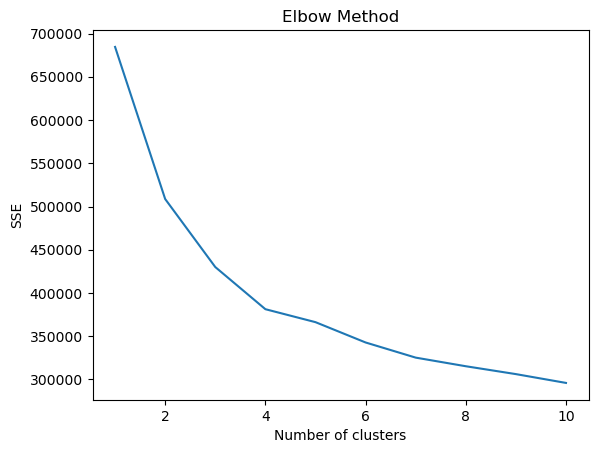

In [46]:
# Determine the optimal number of clusters using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_df_no_target)
    sse.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [47]:
# Choose the optimal number of clusters (for example, k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(train_df_no_cluster)


KMeans(n_clusters=3, random_state=42)

In [48]:
# Assign clusters to the training data (exclude 'target' column during assignment)
train_df['Cluster'] = kmeans.labels_

In [49]:
# Function to predict cluster for a new data point
def predict_cluster(new_data, kmeans, scaler, label_encoders):
    new_data = pd.DataFrame([new_data])
    new_data, _, _ = preprocess_data(new_data, scaler=scaler, label_encoders=label_encoders)
    
    # Print the shape and columns of the new data point after preprocessing
    print("Shape of the new data point:", new_data.shape)
    print("Columns of the new data point:", new_data.columns)
    print("First few rows of the new data point:", new_data.head())

    # Ensure the new data point has the same columns as the training data (excluding 'Cluster' column)
    new_data = new_data[train_df_no_cluster.columns]
    
    cluster = kmeans.predict(new_data)
    return cluster[0]

In [50]:
# Test the function with a new data point
new_data_point = {
    'T1': -70,
    'T2': -65,
    'T3': -68,
    'T4': -72,
    'T5': -63,
    'T6': -67,
    'T7': -64,
    'T8': -60,
    'T9': -62,
    'T10': -66,
    'T11': -70,
    'T12': -72,
    'T13': -65,
    'T14': -68,
    'T15': -63,
    'T16': -61,
    'T17': -66,
    'T18': -68
}

In [51]:
predicted_cluster = predict_cluster(new_data_point, kmeans, scaler, label_encoders)
print(f"The new data point belongs to cluster {predicted_cluster}")

Shape of the new data point: (1, 18)
Columns of the new data point: Index(['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11',
       'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18'],
      dtype='object')
First few rows of the new data point:          T1        T2        T3        T4        T5        T6        T7  \
0 -0.473214 -0.053629 -0.420083 -0.823257  0.181223 -0.425512  0.327327   

         T8        T9       T10       T11      T12       T13       T14  \
0  0.648743  0.348409 -0.042738 -0.456754 -0.64919 -0.125681 -0.376559   

        T15       T16       T17       T18  
0  0.168347  0.297596 -0.008864 -0.132969  
The new data point belongs to cluster 1


In [52]:
# Function to explain why a data point belongs to a specific cluster
def explain_cluster(data_point, cluster, kmeans):
    cluster_center = kmeans.cluster_centers_[cluster]
    explanation = {}
    for i, feature in enumerate(data_point.keys()):
        explanation[feature] = (data_point[feature], cluster_center[i])
    return explanation

In [53]:
# Explain the cluster assignment for the new data point
explanation = explain_cluster(new_data_point, predicted_cluster, kmeans)
print("Explanation for cluster assignment:")
for feature, values in explanation.items():
    print(f"{feature}: Data Point Value = {values[0]}, Cluster Center Value = {values[1]}")

Explanation for cluster assignment:
T1: Data Point Value = -70, Cluster Center Value = -0.7095556729120022
T2: Data Point Value = -65, Cluster Center Value = -0.7852045368196828
T3: Data Point Value = -68, Cluster Center Value = -0.6696838049610895
T4: Data Point Value = -72, Cluster Center Value = -0.47465712900575296
T5: Data Point Value = -63, Cluster Center Value = -0.17089062144714479
T6: Data Point Value = -67, Cluster Center Value = -0.17734777940171628
T7: Data Point Value = -64, Cluster Center Value = 0.4932576511546616
T8: Data Point Value = -60, Cluster Center Value = 0.8083765847819266
T9: Data Point Value = -62, Cluster Center Value = 0.8513272798040277
T10: Data Point Value = -66, Cluster Center Value = -0.7853260535901091
T11: Data Point Value = -70, Cluster Center Value = -0.7694208181890836
T12: Data Point Value = -72, Cluster Center Value = -0.7632291491622828
T13: Data Point Value = -65, Cluster Center Value = -0.5753920395619537
T14: Data Point Value = -68, Cluster 